# 1 Constructing the Matrix $X$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix, csc_matrix
from scipy.sparse.linalg import lsqr

In [2]:
def construct_X(M, alphas, Np = None):
    if Np is None:
        Np = np.ceil(np.sqrt(2) * M)
                
    # Tomograph pixel center array
    # Coord origin is the array center
    C = np.mgrid[-M/2+0.5:M/2+0.5,-M/2+0.5:M/2+0.5].reshape(2,-1)
    
    alphas = np.radians(alphas)
         
    # Orientation of the sensor array
    n = np.asarray([np.matmul(np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]]).T,(1,0)) for a in alphas])
    
    # Project onto line through origin in direction n
    # And shift back, so that we hit the center of the sensor
    p = np.matmul(n[:,np.newaxis,:], C).squeeze()

    # How big is the overlap between rays of size 1 and the hit sensors
    weights = np.stack((np.floor(p) - p + 1, p - np.ceil(p) + 1), axis=-1)

    # Tomography indices according to formula given
    j_indices = np.transpose(np.tile(C[0,:]+M/2-0.5 + M*(C[1,:]+M/2-0.5),(alphas.shape[0],2,1)),(0,2,1))
    
    # Index of the angles
    i_o = np.transpose(np.tile(np.repeat(np.arange(alphas.shape[0]), M*M).reshape(-1,M*M),(2,1,1)),(1,2,0))
    
    # Indices of the hit sensors
    i_low = np.floor(p)+Np/2
    i_high = np.ceil(p)+Np/2
    i_indices = np.stack((i_low, i_high),axis=-1) + Np*i_o
    
    return coo_matrix(
        (weights.flatten(), (i_indices.flatten(), j_indices.flatten())),
        shape=(Np*alphas.shape[0], M*M),
        dtype=np.float32
    )

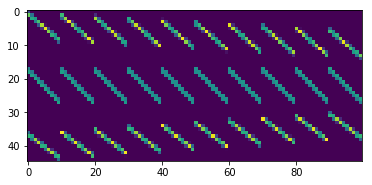

In [3]:
X = construct_X(10, np.array([-33, 1, 42]))

X_ex = np.load('hs_tomography/X_example.npy')

assert np.array_equal(X.toarray(),X_ex)

plt.imshow(X.toarray())
plt.show()

# 2 Reconstructing the image

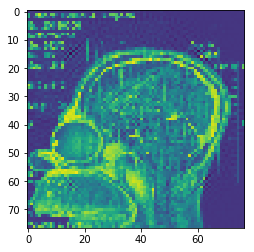

In [4]:
alphas = np.load('hs_tomography/alphas_77.npy')

X = csc_matrix(construct_X(77, alphas, Np=109))

y = np.load('hs_tomography/y_77.npy')

mu = lsqr(X, y)[0].reshape(77,77)

plt.imshow(mu)
plt.show()

In [24]:
alphas = np.load('hs_tomography/alphas_195.npy')
y = np.load('hs_tomography/y_195.npy')

X = csc_matrix(construct_X(195, alphas, Np=275))

print('Number of non-zero elements: {}'.format(X.count_nonzero()))
print('X is {:.2%} sparse'.format(X.count_nonzero()/X.shape[0]/X.shape[1]))

Number of non-zero elements: 13551667
X is 0.72% sparse


In [25]:
mu = lsqr(X, y, atol=1e-8, btol=1e-8)[0].reshape(195,195)

plt.imshow(mu)
plt.show()

# 3 Minimizing Radiation Dose

In [27]:
steps = [2, 5, 10, 15, 30, 45]

fig, axes = plt.subplots(3, 3)

for step, ax in zip(steps, axes.flat):
    X = csc_matrix(construct_X(195, alphas[::step], Np=275))
    mu = lsqr(X, y.reshape(-1,275)[::step].flatten())[0].reshape(195,195)
    ax.imshow(mu)

plt.show()